In [1]:
from spiral import *
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.nn import Parameter
import sys
from torchvision import datasets, transforms
import pickle
import os
import random
import time
import numpy.random as npr
%matplotlib inline
sys.path.append('/home/hao/Research/probtorch/')
from probtorch.util import expand_inputs
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 0.4.0 cuda: True


In [2]:
# model parameters
NUM_HIDDEN = 40
NUM_LATENTS = 2
NUM_OBS = 2
# training parameters
NUM_SAMPLES = 1
BATCH_SIZE = 500
NUM_EPOCHS = 2
LEARNING_RATE = 1e-4
CUDA = torch.cuda.is_available()

RESTORE = False

In [3]:
num_clusters = 5           # number of clusters in pinwheel data
samples_per_cluster = 100  # number of samples per cluster in pinwheel
K = 15                     # number of components in mixture model
N = 2                      # number of latent dimensions
P = 2 
train_dataset = make_pinwheel_data(0.3, 0.05, num_clusters, samples_per_cluster, 0.25)
dataset_size = num_clusters * samples_per_cluster

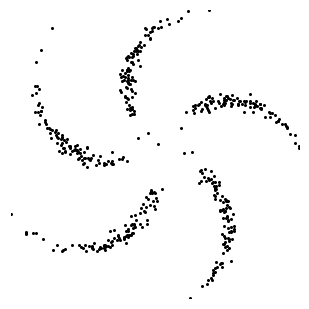

In [4]:
plot_data(train_dataset)

In [5]:
class Encoder(nn.Module):
    def __init__(self, num_obs=NUM_OBS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        self.enc_hidden = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU())
        self.latent_mean = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        self.latent_log_std = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        
    @expand_inputs
    def forward(self, obs, num_samples=None):
        q = probtorch.Trace()
        hidden = self.enc_hidden(obs)
        eta1 = self.latent_mean(hidden)
        eta2 = -1 * torch.exp(self.latent_log_std(hidden))
        latents_std = (-1 / 2) * (1 / eta2)
        batch_size = latents_std.shape[1]
        latents_mean = torch.mul(latents_std, eta1)
        full_std = latents_std.repeat(NUM_LATENTS, 1, 1, 1).permute(1, 2, 3, 0)
        filter_std = torch.eye(NUM_LATENTS).repeat(batch_size, 1, 1).unsqueeze(0).cuda()
        full_latents_std = torch.mul(full_std, filter_std)
#         full_std = torch.zeros((batch_size, NUM_LATENTS, NUM_LATENTS))
#         for n in range(batch_size):
#             full_std[n] = torch.diag(latents_std[0, n])
#         if CUDA:
#             full_std = full_std.cuda()
#         full_std = full_std.unsqueeze(0)
     
        
        q.multivariate_normal(latents_mean, full_latents_std, name='z')
        return q

In [6]:
class Decoder(nn.Module):
    def __init__(self, num_obs=NUM_OBS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS,
                       num_samples=NUM_SAMPLES):
        super(self.__class__, self).__init__()
        self.dec_hidden = nn.Sequential(
            nn.Linear(num_latents, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_obs)
            )


    def forward(self, obs, q=None, num_samples=None):
        p = probtorch.Trace()
        batch_size = obs.shape[0]
        prior_mean = torch.zeros((NUM_SAMPLES, batch_size, NUM_LATENTS)).cuda()
        prior_cov = torch.ones((NUM_SAMPLES, batch_size, NUM_LATENTS)).cuda()
        
        latents = p.normal(prior_mean, prior_cov, value=q['z'], name='z')   
        obs_recon = self.dec_hidden(latents)
        p.loss(mse_loss, obs_recon, obs, name='observations')
        return p


In [7]:
def mse_loss(x_hat, x):
    return torch.norm(x_hat - x, p=2, dim=-1)
def l1_loss(x_hat, x):
    return torch.abs(x_hat - x).sum(-1)

In [8]:
def initialize():
    enc = Encoder()
    dec = Decoder()
    if CUDA:
        enc.cuda()
        dec.cuda()
    optimizer =  torch.optim.Adam(list(enc.parameters())+list(dec.parameters()),lr=LEARNING_RATE)    
    return enc, dec, optimizer

In [9]:
def elbo(q, p):
    if NUM_SAMPLES is None:
        elbo = probtorch.objectives.montecarlo.elbo(q, p, sample_dim=None, batch_dim=0)
        return elbo
    else:
        elbo = probtorch.objectives.montecarlo.elbo(q, p, sample_dim=0, batch_dim=1)
        return elbo

In [10]:
def shuffler(train_dataset):
    index = np.arange(train_dataset.shape[0])
    np.random.shuffle(index)
    return train_dataset[index, :]

def NUM_ITERS(train_dataset, batch_size):
    remainder = train_dataset.shape[0] % batch_size
    if remainder == 0:
        num_iters = int(train_dataset.shape[0] / batch_size)
    else:
        num_iters = int(((train_dataset.shape[0] - remainder) / batch_size) + 1)
    return num_iters

In [11]:
def train(enc, dec, optimizer):
    if RESTORE == False:
        num_iters = NUM_ITERS(train_dataset, BATCH_SIZE)
        elbos_list = []
        time_start = time.time()
        
        for epoch in range(NUM_EPOCHS):
            train_dataset_shuffled = shuffler(train_dataset)
            epoch_elbo = 0.0
            N = 0.0
            for i in range(num_iters):
                data = train_dataset_shuffled[i * BATCH_SIZE : (i + 1) * BATCH_SIZE, :]
                data = torch.FloatTensor(data)
                if CUDA:
                    data = data.cuda()
           
                optimizer.zero_grad()
                q = enc(data, num_samples=NUM_SAMPLES)
                p = dec(data, q, num_samples=NUM_SAMPLES)
                ave_elbo = elbo(q, p)
                loss = -ave_elbo
                loss.backward()
                optimizer.step()
                if CUDA:
                    loss = loss.cpu()
                    epoch_elbo += -loss.data.numpy()
            epoch_elbo /= num_iters
            elbos_list.append(epoch_elbo)
            if epoch % 1 == 0:
                time_end = time.time()
                print('Epoch : %d, ELBO : %f (%ds)' % (epoch+1, epoch_elbo, time_end - time_start))
                time_start = time.time()
        return elbos_list 

In [12]:
enc, dec, optimizer = initialize()
elbos_list = train(enc, dec, optimizer)

Epoch : 1, ELBO : -10.460518 (5s)
Epoch : 2, ELBO : -10.423105 (5s)


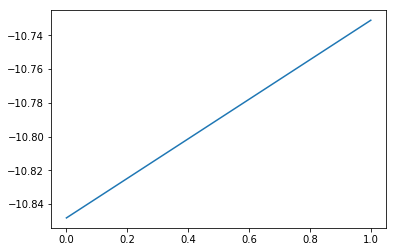

In [13]:
plt.plot(elbos_list)

In [24]:
enc, dec, optimizer = initialize()
for i in range(10):
    data = train_dataset[i * BATCH_SIZE : (i + 1) * BATCH_SIZE, :]
    data = torch.FloatTensor(data)
    if CUDA:
        data = data.cuda()
    break 
q = probtorch.Trace()
hidden = enc.enc_hidden(data)
eta1 = enc.latent_mean(hidden).unsqueeze(0)
eta2 = -1 * torch.exp(enc.latent_log_std(hidden)).unsqueeze(0)
latents_std = (-1 / 2) * (1 / eta2)
batch_size = latents_std.shape[1]
latents_mean = torch.mul(latents_std, eta1)
full_std = latents_std.repeat(NUM_LATENTS, 1, 1, 1).permute(1, 2, 3, 0)
filter_std = torch.eye(NUM_LATENTS).repeat(batch_size, 1, 1).unsqueeze(0).cuda()
full_latents_std = torch.mul(full_std, filter_std)
#         full_std = torch.zeros((batch_size, NUM_LATENTS, NUM_LATENTS))
#         for n in range(batch_size):
#             full_std[n] = torch.diag(latents_std[0, n])
#         if CUDA:
#             full_std = full_std.cuda()
#         full_std = full_std.unsqueeze(0)


# q.multivariate_normal(latents_mean, full_latents_std, name='z')

In [26]:
full_std[0,0]

tensor([[ 0.6543,  0.6543],
        [ 0.3834,  0.3834]], device='cuda:0')

In [27]:
full_latents_std[0,0]

tensor([[ 0.6543,  0.0000],
        [ 0.0000,  0.3834]], device='cuda:0')